In [ ]:
#IMAGE PREPROCESSING

In [1]:
import pandas as pd
import shutil
import os
import pydicom as pydicom
import numpy as np
import matplotlib.pyplot as plt
import scipy
from  scipy import ndimage

class ImagePreprocessing:

    def __init__ (self, path_to_save, path_image, dicom, img_width, img_height):
    
        self.path_to_save = path_to_save
        self.path_image_dicom = path_image+dicom
        self.dicom=dicom.split('/')[0]
        self.img_width= img_width
        self.img_height= img_height

    def folders(self):
        if not os.path.exists(self.path_to_save): os.mkdir(self.path_to_save)  
        if not os.path.exists(self.path_to_save+'HISTOGRAM/'): os.mkdir(self.path_to_save+'HISTOGRAM/')  
        if not os.path.exists(self.path_to_save+'CSV/'): os.mkdir(self.path_to_save+'CSV/')  
        if not os.path.exists(self.path_to_save+'SLICES/'): os.mkdir(self.path_to_save+'SLICES/')  
        if not os.path.exists(self.path_to_save+'PREPROCESSED/'): os.mkdir(self.path_to_save+'PREPROCESSED/')  
        
        self.label, self.filename, self.nid, self.nsn, self.ne, self.ps, self.pa, self.st, self.slen = [], [], [], [], [], [], [], [], []


    #1. LOAD IMAGE:
    def load_scan(self): #path

        #will load all DICOM images from a folder into a list for manipulation.
        self.slices = [pydicom.read_file(self.path_image_dicom + '/' + s, force=True) for s in os.listdir(self.path_image_dicom)]

        self.slices.sort(key = lambda x: float(x.ImagePositionPatient[2]))  
        try:
            slice_thickness = np.abs(self.slices[0].ImagePositionPatient[2] - self.slices[1].ImagePositionPatient[2])
        except:
            slice_thickness = np.abs(self.slices[0].SliceLocation - self.slices[1].SliceLocation)

        for s in self.slices:
            s.SliceThickness = slice_thickness

        self.extraerdatos()


    #2. CONVERT RAW DATA INTO HOUNSFIELD UNITS, PRIOR TO NORMALISING:
    def get_pixels_hu(self):  #slices
        
        #The voxel values in the images are raw. get_pixels_hu converts raw values into HU. The transformation is linear. Therefore, so long as you have a slope and an intercept, you can rescale a voxel value to HU.
        #Both the rescale intercept and rescale slope are stored in the DICOM header at the time of image acquisition (these values are scanner-dependent, so you will need external information).

        image = np.stack([s.pixel_array for s in self.slices])  
        self.hist("_beforeHU", image, "Raw data")
        self.sample_stack('_beforeHU', image)
        image = image.astype(np.float32)
        

        # Set outside-of-scan pixels to 0. 
        # The intercept is usually -1024, so air is approximately 0 (sin unidad, es -1000 en UH).
        image[image == -2000] = 0
        
        # Convert to Hounsfield units (HU)
        for slice_number in range(len(self.slices)):
            intercept = self.slices[slice_number].RescaleIntercept
            slope = self.slices[slice_number].RescaleSlope

            if slope != 1:
                image[slice_number] = slope * image[slice_number].astype(np.float64)
                image[slice_number] = image[slice_number].astype(np.int16)

            image[slice_number] += np.int16(intercept)
        self.image = np.array(image, dtype=np.int16)
        
        self.hist("_afterHU", image, "Hounsfield Units")
        self.sample_stack("_afterHU", image)

        
    #3. NORMALIZAR:
    def normalize(self,image):
        MIN_BOUND=15
        MAX_BOUND=100

        image = (image - MIN_BOUND) / (MAX_BOUND - MIN_BOUND)
        image[image>1] = 0.
        image[image<0] = 0.
        return image



    #4. RESAMPLING: 
    def resample(self,image, scan, new_spacing=[5,5,5]):
        # Determine current pixel spacing
        pi=scan[0].PixelSpacing
        pi=pi[0]
        spacing = np.array(scan[0].SliceThickness + pi,np.float32)

        resize_factor = spacing / new_spacing
        new_real_shape = image.shape * resize_factor
        new_shape = np.round(new_real_shape)
        real_resize_factor = new_shape / image.shape
        new_spacing = spacing / real_resize_factor
        image = scipy.ndimage.interpolation.zoom(image, real_resize_factor, mode='nearest')

        return image, new_spacing


    #5. "PREPROCESADO" o RESAMPLING_AVANZADO (es decir, que todos los pacientes tengan el mismo número de slices): 
    def preprocesado(self): #todos los pacientes tienen que tener el mismo númro de cortes.     
        pix_resampled, spacing = self.resample(self.image, self.slices, [5,5,5])

        pixels_n=[]
        for s in pix_resampled:
            pixels1=s
            pixels1=self.normalize(pixels1) #SE NORMALIZAN AQUÍ
            pixels1=list(pixels1)
            pixels_n.append(pixels1)

        pixels_n=np.array(pixels_n)
        self.hist("_PREPROCESSED", pixels_n, "Hounsfield Units")
        self.sample_stack("_PREPROCESSED", pixels_n)

        np.save(self.path_to_save+'PREPROCESSED/HIC_'+str(self.dicom)+'.npy', pixels_n)

    def sample_stack(self,title, stack, rows=4, cols=4, start_with=0, show_every=1):
        fig,ax = plt.subplots(rows, cols, figsize=(12,12))
        for i in range(rows*cols):
            ind = start_with + i*show_every
            ax[int(i/rows),int(i % rows)].set_title('slice %d' % ind)
            ax[int(i/rows),int(i % rows)].imshow(stack[ind],cmap='gray')
            ax[int(i/rows),int(i % rows)].axis('off')
        plt.savefig(self.path_to_save + 'SLICES/'"HIC_"+str(self.dicom)+'_'+title+".jpg")
        plt.show()

    def hist(self, filename, stack, xlabel):
        plt.hist(stack.flatten(), bins=80)
        plt.xlabel(xlabel)
        plt.ylabel("Frequency")
        plt.savefig(self.path_to_save + 'HISTOGRAM/HIC_'+str(self.dicom)+'_'+filename+".jpg")
        plt.show()

    def extraerdatos(self):
        self.filename.append('HIC_'+str(self.dicom))
        self.nid.append(self.slices[0].PatientID)
        self.nsn.append(self.slices[0].AccessionNumber)
        self.ne.append(self.slices[0].Manufacturer)
        self.ps.append(self.slices[0].PatientSex)
        #self.pa.append(self.slices[0].PatientAge)
        self.st.append(self.slices[0].SliceThickness)
        self.slen.append(len(self.slices))
        self.label.append(str(1))
        print('PatientID: '+str(self.nid[-1]) +' - Manufacturer: '+str(self.ne[-1]), '- PatientSex: '+str(self.ps[-1]))#+'- PatientAge: '+str(self.pa[-1]))
        
        
    def My_model_runall(self):
        self.folders()
        print('[INFO] LOAD DICOM')
        self.load_scan()

        print('[INFO] GET PIXELS HU')                           
        self.get_pixels_hu()

        print('[INFO] PREROCESSED')
        self.preprocesado() 

        data = {'Patient': self.filename,
                'PatientID': self.nid,
                'AccessionNumber': self.nsn,
                'Manufacturer': self.ne,
                'SliceThickness': self.st,
                'SlicesNumber': self.slen,
                'PatientSex': self.ps,
                #'PatientAge':pa,
                'Label': self.label,
               }

        df = pd.DataFrame(data, columns = ['Patient', 'PatientID', 'AccessionNumber','Manufacturer', 'SliceThickness', 'SlicesNumber', 'PatientSex','Label']) #'PatientAge'
        df.to_csv(self.path_to_save+'CSV/DICOM_PatientID_AccessionNumber_Manufacturer_SliceThickness_SlicesNumber_PatientSex_Label.csv', index=False)

[INFO] LOAD DICOM
PatientID: 9 - Manufacturer: GE MEDICAL SYSTEMS - PatientSex: 
[INFO] GET PIXELS HU


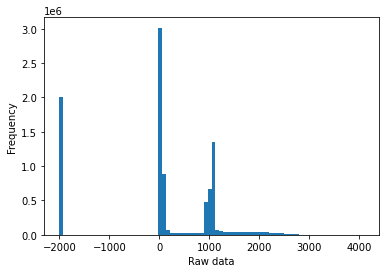

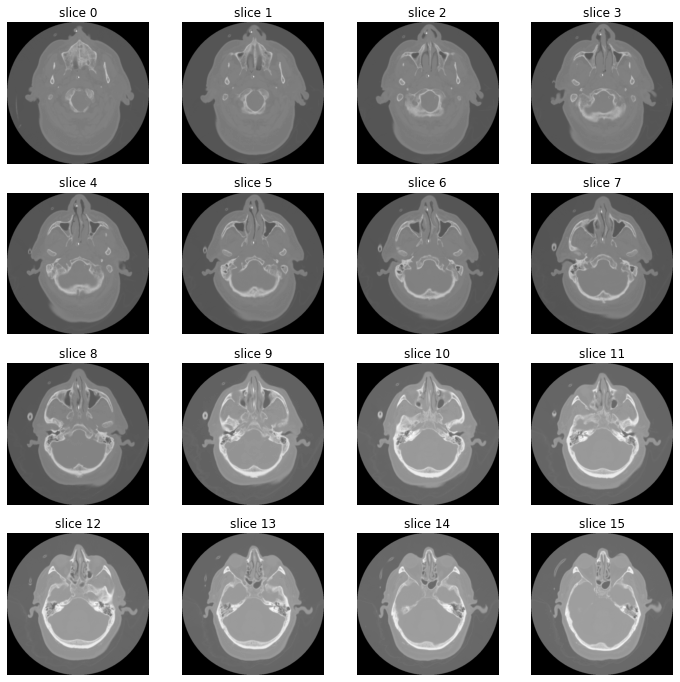

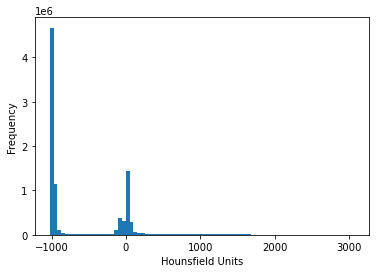

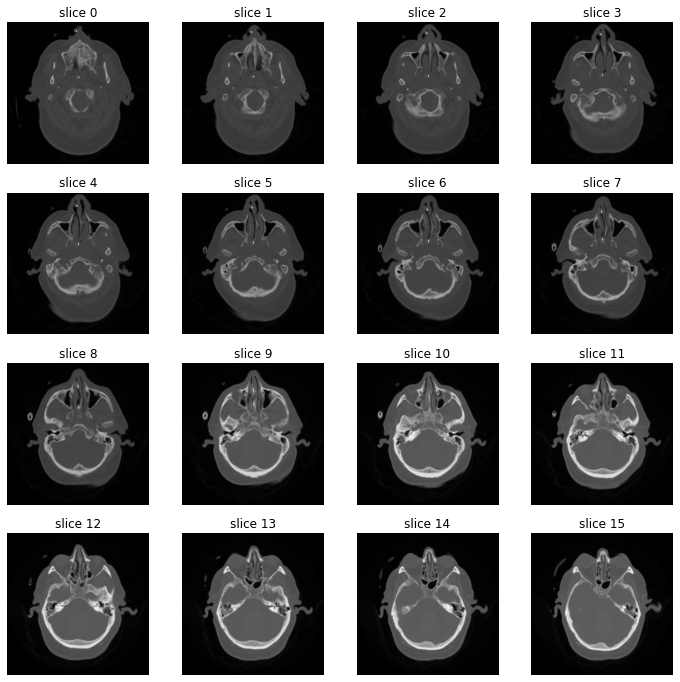

[INFO] PREROCESSED


/tmp/ipykernel_979017/2436697316.py:104: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  image = scipy.ndimage.interpolation.zoom(image, real_resize_factor, mode='nearest')


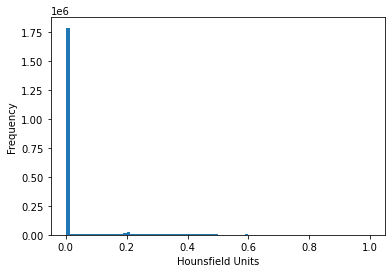

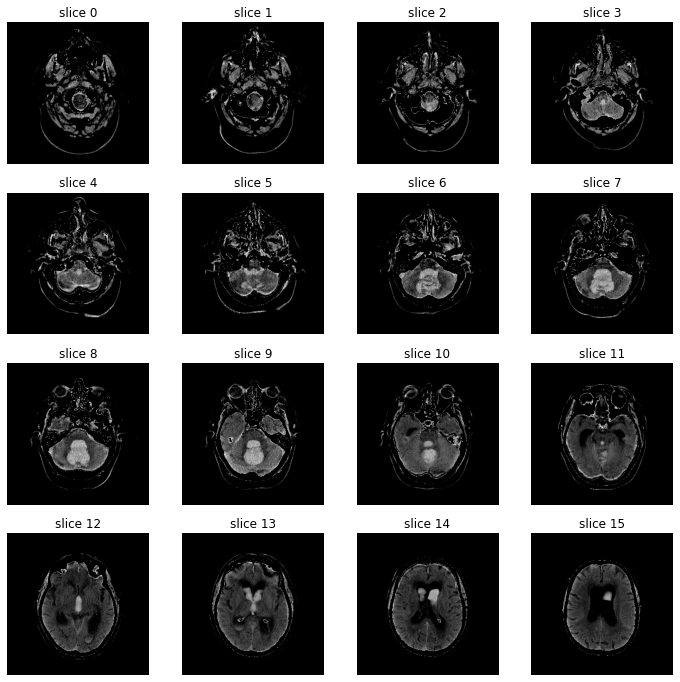

In [2]:
My_model= ImagePreprocessing(
                            path_to_save = '/home/jovyan/IMAGE_PREPROCESSING_2D_3D/PREPROCESSED DATA/',
                            path_image = '/home/jovyan/IMAGE_PREPROCESSING_2D_3D/DICOM/',
                            dicom='9/13016/2/',
                            img_width =128,
                            img_height = 128
                            )


My_model.My_model_runall()